In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import time
from datetime import datetime
from sklearnex import patch_sklearn
patch_sklearn()
from hpsklearn import *
from hyperopt import hp, tpe

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
C:\Users\marce\anaconda3\envs\tf\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
SEED = 10
limit_rows = None

In [3]:
print(f"Execution started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution started at 2022-03-02 04:48:45.


In [4]:
def load_csv(name):
    if limit_rows is None:
        full_filename = f'../Data Preprocessing/sklearn/full/iot23_combined_{name}.csv'
    else:
        full_filename = f'../Data Preprocessing/sklearn/semi/iot23_combined_{int(limit_rows/1000)}k_{name}.csv'
    
    df = pd.read_table(filepath_or_buffer=full_filename, header=None, sep=',').infer_objects().to_numpy()
    
    return df.ravel() if df.shape[1] == 1 else df

In [5]:
X_train, X_test, y_train, y_test = load_csv('X_train'), load_csv('X_test'), load_csv('y_train'), load_csv('y_test')

print('X_train',X_train.shape,'\ny_train',y_train.shape)
print('X_test',X_test.shape,'\ny_test',y_test.shape)

X_train (7142855, 15) 
y_train (7142855,)
X_test (1785714, 15) 
y_test (1785714,)


In [6]:
def build_clf_name(clf):
    clf_name = clf.name.replace('sklearn_','').replace('Classifier','')
    if clf_name == 'switch':
        clf_name = 'SVC-LL'
    elif 'SVC' in clf_name:
        for arg in clf.named_args:
            if arg[0] == 'kernel':
                clf_name += f'-{arg[1].obj.capitalize()[0]}'
    clf_name = ''.join(c for c in clf_name if (c.isupper() or c == '-'))
    return clf_name

In [7]:
classifiers = [
    ada_boost('ab'),
    decision_tree('dt'),
    extra_trees('et'),
    gaussian_nb('gnb'),
    gradient_boosting('gb'),
    knn('knn'),
    liblinear_svc('svc-ll'),
    linear_discriminant_analysis('lda',n_components=1),
    multinomial_nb('mnb'),
    one_vs_one('ovo'),
    one_vs_rest('ovr'),
    output_code('oc'),
    passive_aggressive('pa'),
    quadratic_discriminant_analysis('qda'),
    random_forest('rf'),
    sgd('sgd'),
    svc('svc'),
    svc_linear('svc-l'),
    svc_poly('svc-p'),
    svc_rbf('svc-r'),
    svc_sigmoid('svc-s'),
    xgboost_classification('xgb')
]

In [8]:
best_results = {}

for clf in classifiers:
    
    clf_name = build_clf_name(clf)
    
    print(f'\n******************** {clf_name} ********************')
    
    best_results[clf_name] = (0.0, None)
        
    try:
        estim = HyperoptEstimator(classifier=clf,
                                  preprocessing=[],
                                  algo=tpe.suggest,
                                  max_evals=10,
                                  trial_timeout=600,
                                  seed=np.random.default_rng(SEED),
                                  fit_increment=1,
                                  fit_increment_dump_filename=f'hyperopt_increments/{clf_name}.inc',
                                  n_jobs=1)
    except Exception as e:
        print(f"********** Could not create {clf_name}. Reason: '{str(e)}'. **********")
        
    try:
        estim.fit(X_train, y_train, random_state=SEED)
    except Exception as e:
        print(f"********** Could not fit {clf_name}. Reason: '{str(e)}'. **********")
        
    try:
        score = estim.score(X_test, y_test)
        best_model = estim.best_model()
        best_results[clf_name] = (score, best_model)
        print(best_results[clf_name])
    except Exception as e:
        print(f"********** Could not evaluate {clf_name}. Reason: '{str(e)}'. **********")


******************** AB ********************
100%|███████████████████████████████████████████████████████████████████| 1/1 [10:01<00:00, 601.64s/trial, best loss=?]
********** Could not fit AB. Reason: ''. **********
********** Could not evaluate AB. Reason: 'Attempting to use a model that has not been fit. Ensure fit() has been called and at least one trial has completed without failing or timing out.'. **********

******************** DT ********************
100%|█████████████████████████████████████████████| 10/10 [00:14<00:00, 15.00s/trial, best loss: 0.0022575006772501682]
(0.9976950396312063, {'learner': DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=9, random_state=1,
                       splitter='random'), 'preprocs': (), 'ex_preprocs': ()})

******************** ET ********************
100%|█████████████████████████████████████████████| 10/10 [10:02<00:00, 602.07s/trial, best loss: 0.012800203840061197]
(0.993591918974707, {'learner': ExtraTreesClassifier(boo

100%|███████████████████████████████████████████████| 10/10 [00:11<00:00, 11.41s/trial, best loss: 0.28726118617835583]
(0.7126846740295478, {'learner': MultinomialNB(alpha=0.38), 'preprocs': (), 'ex_preprocs': ()})

******************** OVO ********************
 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:00<?, ?trial/s, best loss=?]

job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)



 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:07<?, ?trial/s, best loss=?]
********** Could not fit OVO. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********
********** Could not evaluate OVO. Reason: 'This OneVsOneClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.'. **********

******************** OVR ********************
 75%|█████████████████████████████████████████████████████████                   | 3/4 [00:00<?, ?trial/s, best loss=?]

job exception: bad allocation



 75%|█████████████████████████████████████████████████████████                   | 3/4 [00:07<?, ?trial/s, best loss=?]
********** Could not fit OVR. Reason: 'bad allocation'. **********
********** Could not evaluate OVR. Reason: 'This OneVsRestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.'. **********

******************** OC ********************
 75%|█████████████████████████████████████████████████████████                   | 3/4 [00:00<?, ?trial/s, best loss=?]

job exception: bad allocation



 75%|█████████████████████████████████████████████████████████                   | 3/4 [00:15<?, ?trial/s, best loss=?]
********** Could not fit OC. Reason: 'bad allocation'. **********
********** Could not evaluate OC. Reason: 'This OutputCodeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.'. **********

******************** PA ********************
100%|███████████████████████████████████████████████| 10/10 [05:00<00:00, 300.92s/trial, best loss: 0.2824780847434254]
(0.7166953946712632, {'learner': PassiveAggressiveClassifier(C=0.037702012671071344, fit_intercept=False,
                            loss='squared_hinge', max_iter=11587094.0, n_jobs=1,
                            random_state=4, tol=4.53027677686769e-05,
                            verbose=False), 'preprocs': (), 'ex_preprocs': ()})

******************** QDA ********************
  0%|                                                                            | 0/1 

job exception: y has only 1 sample in class 7, covariance is ill defined.



  0%|                                                                            | 0/1 [00:09<?, ?trial/s, best loss=?]
********** Could not fit QDA. Reason: 'y has only 1 sample in class 7, covariance is ill defined.'. **********
********** Could not evaluate QDA. Reason: 'Attempting to use a model that has not been fit. Ensure fit() has been called and at least one trial has completed without failing or timing out.'. **********

******************** RF ********************
100%|████████████████████████████████████████████| 10/10 [10:04<00:00, 604.07s/trial, best loss: 0.0037289011186703025]
(0.9965324794451967, {'learner': RandomForestClassifier(max_features=0.29064251968408905, min_samples_leaf=32,
                       n_estimators=85, n_jobs=1, random_state=4,
                       verbose=False), 'preprocs': (), 'ex_preprocs': ()})

******************** SGD ********************
100%|███████████████████████████████████████████████| 10/10 [10:03<00:00, 603.86s/trial, best loss: 0

ERROR:hyperopt.fmin:job exception: bad allocation


  0%|                                                                            | 0/1 [00:20<?, ?trial/s, best loss=?]
********** Could not fit SVC-LL. Reason: 'bad allocation'. **********
********** Could not evaluate SVC-LL. Reason: 'Attempting to use a model that has not been fit. Ensure fit() has been called and at least one trial has completed without failing or timing out.'. **********

******************** SVC-L ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: bad allocation


  0%|                                                                            | 0/1 [05:20<?, ?trial/s, best loss=?]
********** Could not fit SVC-L. Reason: 'bad allocation'. **********
********** Could not evaluate SVC-L. Reason: 'Attempting to use a model that has not been fit. Ensure fit() has been called and at least one trial has completed without failing or timing out.'. **********

******************** SVC-P ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


  0%|                                                                            | 0/1 [00:12<?, ?trial/s, best loss=?]
********** Could not fit SVC-P. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********
********** Could not evaluate SVC-P. Reason: 'Attempting to use a model that has not been fit. Ensure fit() has been called and at least one trial has completed without failing or timing out.'. **********

******************** SVC-R ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: bad allocation


  0%|                                                                            | 0/1 [07:19<?, ?trial/s, best loss=?]
********** Could not fit SVC-R. Reason: 'bad allocation'. **********
********** Could not evaluate SVC-R. Reason: 'Attempting to use a model that has not been fit. Ensure fit() has been called and at least one trial has completed without failing or timing out.'. **********

******************** SVC-S ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: bad allocation


  0%|                                                                            | 0/1 [00:58<?, ?trial/s, best loss=?]
********** Could not fit SVC-S. Reason: 'bad allocation'. **********
********** Could not evaluate SVC-S. Reason: 'Attempting to use a model that has not been fit. Ensure fit() has been called and at least one trial has completed without failing or timing out.'. **********

******************** XGB ********************
100%|███████████████████████████████████████████████████████████████████| 1/1 [10:05<00:00, 605.81s/trial, best loss=?]
********** Could not fit XGB. Reason: ''. **********
********** Could not evaluate XGB. Reason: 'Attempting to use a model that has not been fit. Ensure fit() has been called and at least one trial has completed without failing or timing out.'. **********


In [9]:
best_results = dict(sorted(best_results.items()))
print(json.dumps(best_results, indent=4, default=str))

{
    "AB": [
        0.0,
        null
    ],
    "DT": [
        0.9976950396312063,
        {
            "learner": "DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=9, random_state=1,\n                       splitter='random')",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "ET": [
        0.993591918974707,
        {
            "learner": "ExtraTreesClassifier(bootstrap=True, criterion='entropy',\n                     max_features=0.3826823680920317, min_samples_leaf=2,\n                     n_estimators=23, n_jobs=1, random_state=2, verbose=False)",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "GB": [
        0.0,
        null
    ],
    "GNB": [
        0.27169020347043255,
        {
            "learner": "GaussianNB()",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "KN": [
        0.0,
        null
    ],
    "LDA": [
        0.7072537931606069,
        {
         

['AB', 'DT', 'ET', 'GB', 'GNB', 'KN', 'LDA', 'LSVC', 'MNB', 'OC', 'OVO', 'OVR', 'PA', 'QDA', 'RF', 'SGD', 'SVC-L', 'SVC-LL', 'SVC-P', 'SVC-R', 'SVC-S', 'XGB']
[0.0, 0.9976950396312063, 0.993591918974707, 0.0, 0.27169020347043255, 0.0, 0.7072537931606069, 0.0, 0.7126846740295478, 0.0, 0.0, 0.0, 0.7166953946712632, 0.0, 0.9965324794451967, 0.7154471544715447, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


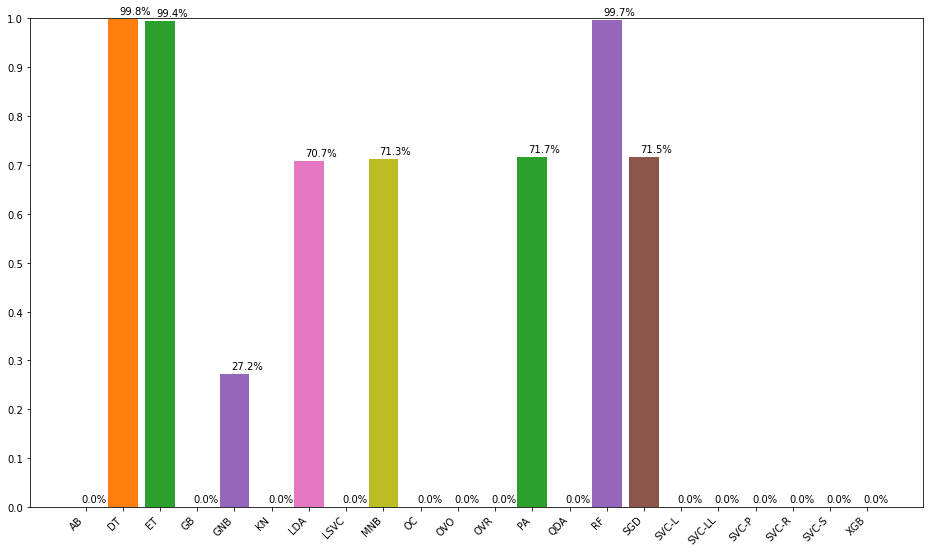

In [10]:
names = list(best_results.keys())
print(names)
values = list(x[0] for x in best_results.values())
print(values)

plt.figure(figsize=(16,9))
idx = 0
for i in range(len(best_results.keys())):
    plt.bar(names[i],values[i])
    plt.text(idx-0.1,values[i]+0.01,f'{100*values[i]:.1f}%')
    idx += 1
plt.xticks(rotation=45, ha='right')
plt.xticks(range(0,len(best_results)),names)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.show()

In [11]:
print(f"Execution finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution finished at 2022-03-02 12:50:38.
